In [19]:
from fastai.vision.all import *
import os
from pathlib import Path

# 1. Update to the 90-animal dataset name
DATASET_FOLDER_NAME = 'animal-image-dataset-90-different-animals'

# 2. Update the path 
input_path = Path(f'../input/{DATASET_FOLDER_NAME}/animals/animals')

# The local folder where we will 'link' the images for training
path = Path('pets_dataset')
path.mkdir(exist_ok=True)

# 3. List of pets
classes = ['cat', 'dog', 'goldfish', 'hamster', 'turtle', 'parrot', 'snake']

for o in classes:
    dest = path/o
    dest.mkdir(exist_ok=True)
    source_folder = input_path/o
    
    if source_folder.exists():
        files = get_image_files(source_folder)
        
        for f in files[:400]:
            target_file = dest/f.name
            
            # Using os.path.lexists is the most reliable way to check for 
            # existing links, even if they are broken.
            if not os.path.lexists(target_file):
                try:
                    os.symlink(f, target_file)
                except FileExistsError:
                    pass
                    
        print(f"✅ Prepared {len(list(dest.iterdir()))} images for {o}")
    else:
        print(f"❌ Error: Folder '{o}' not found in {source_folder}")

✅ Prepared 60 images for cat
✅ Prepared 60 images for dog
✅ Prepared 60 images for goldfish
✅ Prepared 60 images for hamster
✅ Prepared 60 images for turtle
✅ Prepared 60 images for parrot
✅ Prepared 60 images for snake


Checking input path: /kaggle/working/../input/animal-image-dataset-90-different-animals/animals/animals
✅ Prepared 60 images for cat
✅ Prepared 60 images for dog
✅ Prepared 60 images for goldfish
✅ Prepared 60 images for hamster
✅ Prepared 60 images for turtle
✅ Prepared 60 images for parrot
✅ Prepared 60 images for snake


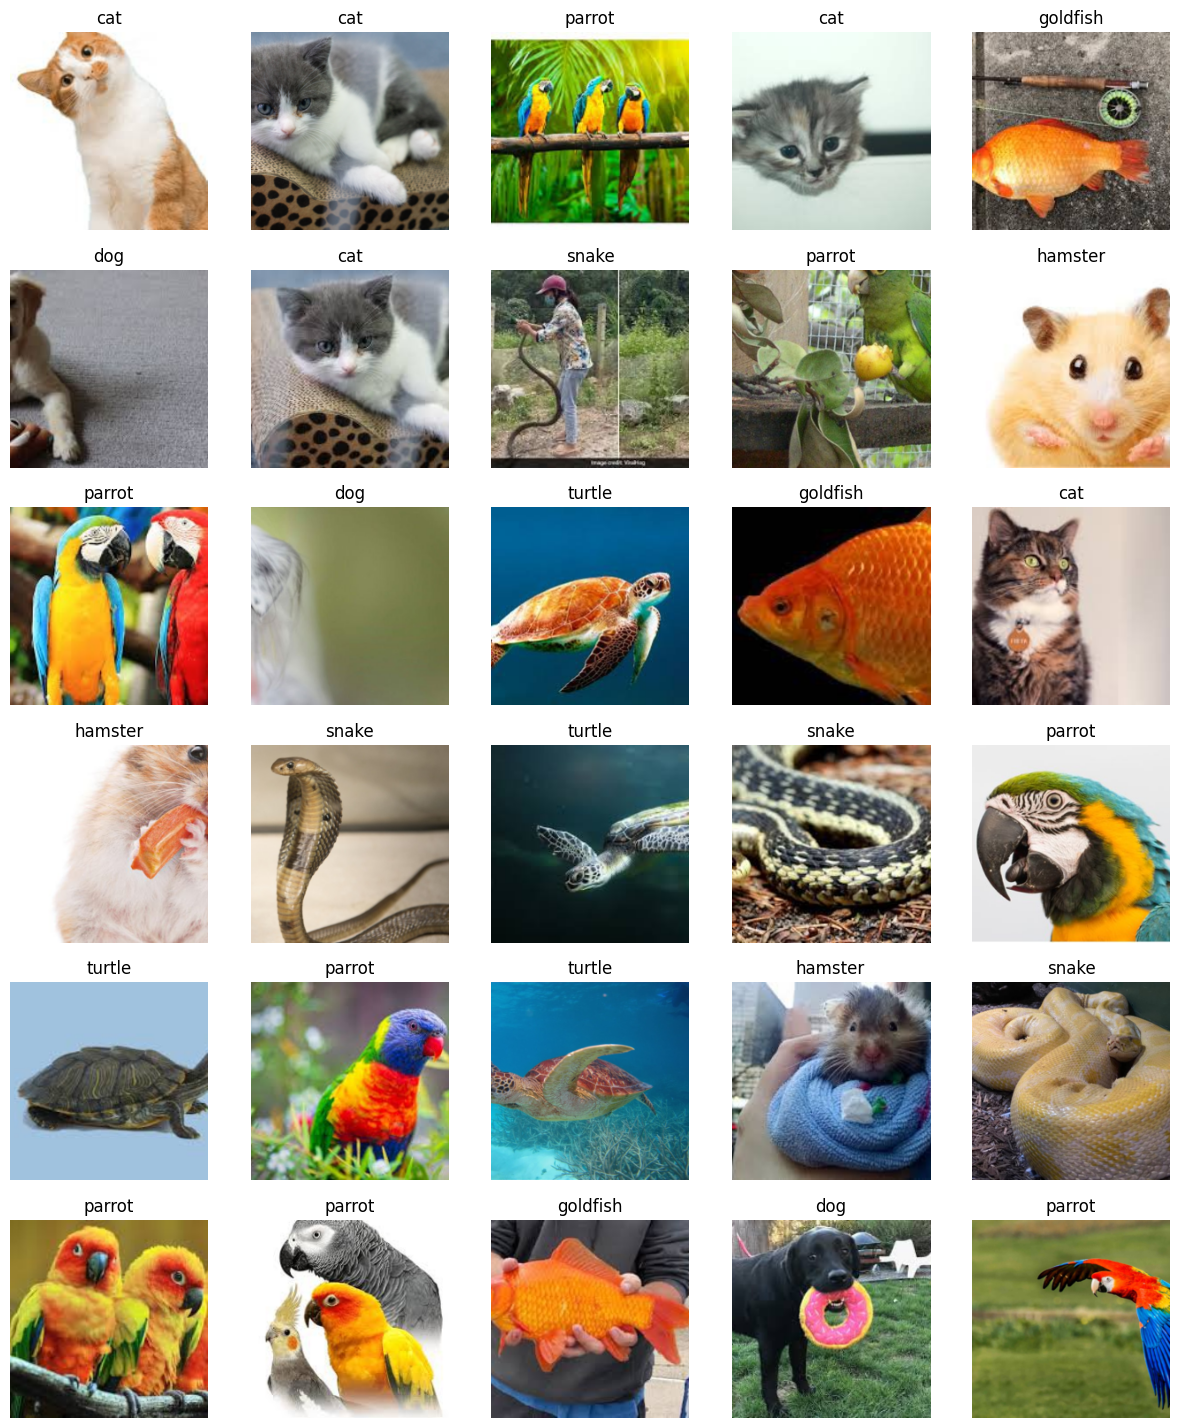

In [33]:
import os, shutil
from pathlib import Path

# 1. DOUBLE CHECK THIS PATH - Based on your error, it's likely missing or slightly different
input_path = Path('../input/animal-image-dataset-90-different-animals/animals/animals')

path = Path('pets_dataset')
classes = ['cat', 'dog', 'goldfish', 'hamster', 'turtle', 'parrot', 'snake']

# Clean start
if path.exists(): shutil.rmtree(path)
path.mkdir(exist_ok=True)

print(f"Checking input path: {input_path.absolute()}")

for o in classes:
    dest = path/o
    dest.mkdir(exist_ok=True)
    source_folder = input_path/o
    
    if source_folder.exists():
        files = get_image_files(source_folder)
        count = 0
        for f in files[:400]:
            # This ensures the actual image exists before we link to it
            if f.exists():
                os.symlink(f.absolute(), dest/f.name)
                count += 1
            else:
                print(f"⚠️ Source file missing: {f}")
        print(f"✅ Prepared {count} images for {o}")
    else:
        print(f"❌ Error: Folder '{o}' not found in {source_folder}")

# 2. Define and Run DataBlock
animals = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224)
)

dls = animals.dataloaders(path)
dls.show_batch(max_n=30, nrows=6)

In [24]:
# 1. Create the learner
# resnet34 is a great balance of speed and accuracy
learn = vision_learner(dls, resnet34, metrics=error_rate)

# 2. Find the best learning rate (optional but helpful)
# learn.lr_find() 

# 3. Train the model for 3 epochs
# 'fine_tune' automatically handles the transfer learning steps for you
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 181MB/s]


[]

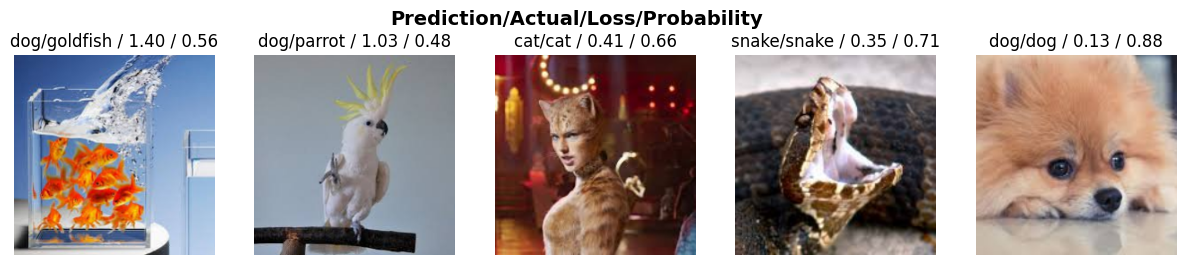

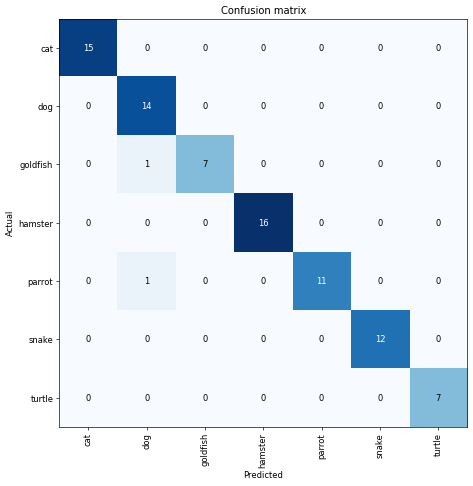

In [26]:
# 1. Look at specific mistakes
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(5, nrows=1)

# 2. Show the Confusion Matrix
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

# 3. See the "Most Confused" list
interp.most_confused(min_val=2)

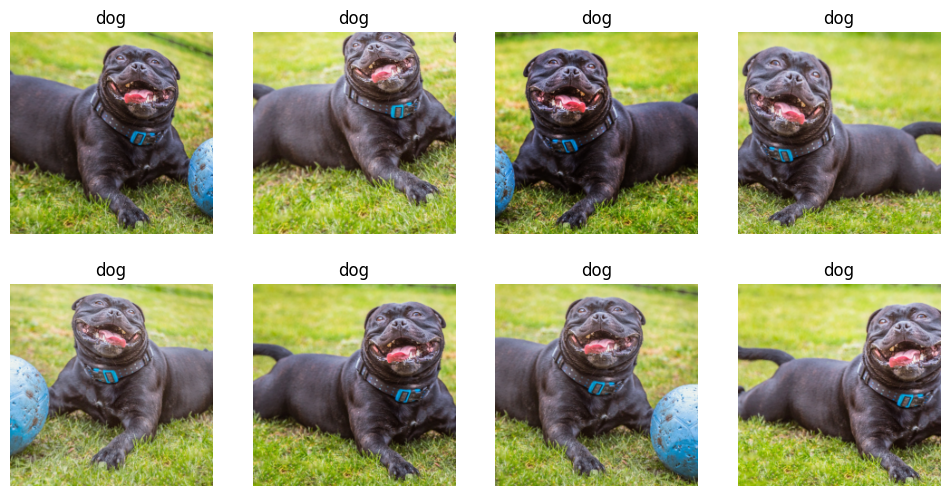

In [27]:
# aug_transforms creates a standard set of augmentations 
# (rotation, flip, brightness, contrast, warp)
animals = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460), # Resize to a larger size first
    batch_tfms=aug_transforms(size=224, min_scale=0.75) # Then crop and augment to 224
)

dls = animals.dataloaders(path)

# Let's see what the model actually "sees" now
dls.show_batch(max_n=8, nrows=2, unique=True)

SuggestedLRs(valley=6.30957365501672e-05)

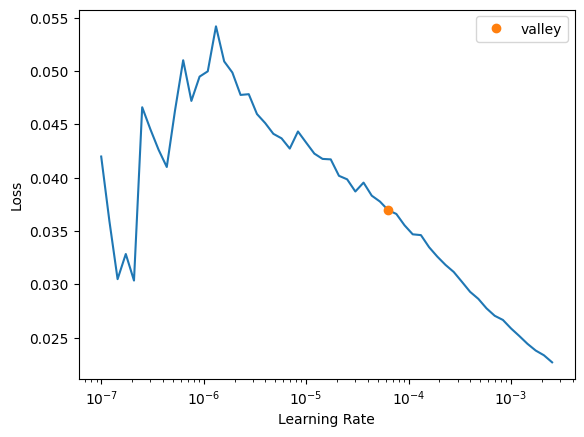

In [28]:
learn.lr_find()

In [29]:
# 1. Train using the suggested learning rate from your plot
# We use 'base_lr' to tell the model exactly what speed to start at
learn.fine_tune(5, base_lr=6.3e-5)

[]

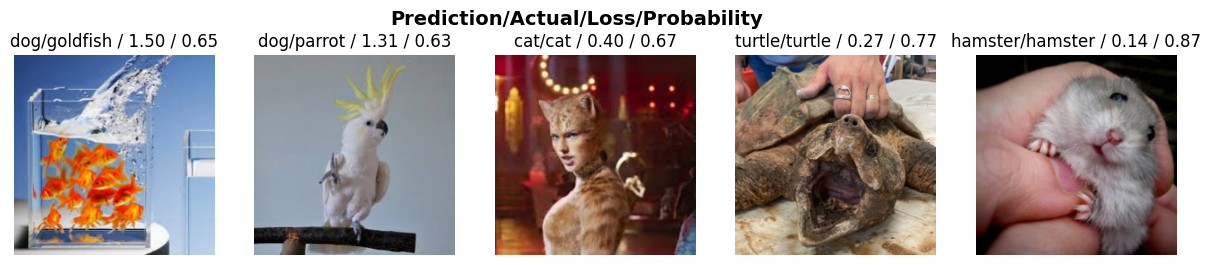

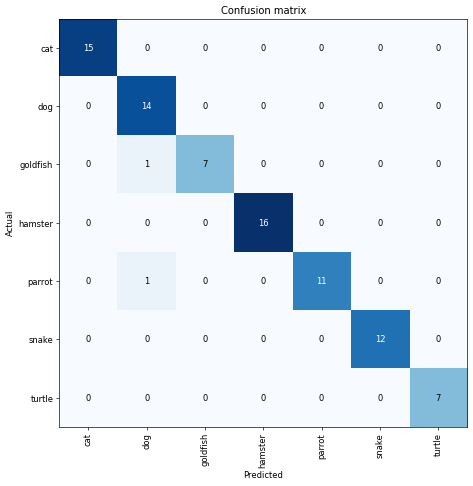

In [31]:
# 1. Look at specific mistakes
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(5, nrows=1)

# 2. Show the Confusion Matrix
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

# 3. See the "Most Confused" list
interp.most_confused(min_val=2)

In [34]:
learn.export('pet_classifier_v1.pkl')